## Reproducing the plots of the paper 
- Here we provide a notebook for reproducing our results using the ADBench suite on the datasets proposed in ADbench. Therefore you need to install the ADbench repository first (see the README for instructions).

In [47]:
from renyi_isolation_forest.depth_based_renyi_isolation_forest import DepthBasedRenyiIsolationForest
from renyi_isolation_forest.pac_based_renyi_isolation_forest import PACBasedRenyiIsolationForest

In [48]:
import os
import sys

# os.chdir("../") # depending on where you start the notebook, you might have to uncomment this line
sys.path.append("../")

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from data_generator import DataGenerator
from myutils import Utils

datagenerator = DataGenerator() # data generator
utils = Utils() # utils function

# Importing the datasets
- All the datasets of ADBench in the "datasets" folder, as the "number_data_class.npz" filename. In this experiements we used 47 datasets

In [49]:
datasets = os.listdir('datasets/Classical')
datasets = [s.split(".")[0] for s in datasets]
dataset_list = datasets

# Fit, predict and evaluate IF variants results

In [50]:
from sklearn.ensemble import IsolationForest
import numpy as np

alphas = [0,0.5,1,2,np.inf]

def bring_in_alphas(name, clf, alphas):
    return [(name + str(alpha),(clf, alpha)) for alpha in alphas]

model_list = [("IForest", (IsolationForest, None))]
model_list.extend(bring_in_alphas("PACForest", PACBasedRenyiIsolationForest, alphas))
model_list.extend(bring_in_alphas("IForestAlpha", DepthBasedRenyiIsolationForest, alphas))
model_dict = dict(model_list)

df_AUCROC = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())

In [ ]:
# seed for reproducible results
seed = 42

for dataset in dataset_list:
    '''
    la: ratio of labeled anomalies, from 0.0 to 1.0
    realistic_synthetic_mode: types of synthetic anomalies, can be local, global, dependency or cluster
    noise_type: inject data noises for testing model robustness, can be duplicated_anomalies, irrelevant_features or label_contamination
    '''
    try:
        # import the dataset
        datagenerator.dataset = dataset
        data = datagenerator.generator(la=0.1, realistic_synthetic_mode=None, noise_type=None) # only 10% labeled anomalies are available
        for name, (clf, alpha) in model_dict.items():
            try:
                print(f"running model {name} for alpha {alpha}")

                clf = clf(random_state=seed)
                # training, for unsupervised models the y label will be discarded
                clf = clf.fit(X=data['X_train'], y=data['y_train'])

                # output predicted anomaly score on testing set
                score = clf.decision_function(data['X_test'], alpha) if alpha is not None else -clf.decision_function(data['X_test'])

                # evaluation
                result = utils.metric(y_true=data['y_test'], y_score=score)

                # save results
                df_AUCROC.loc[dataset, name] = result['aucroc']
                df_AUCPR.loc[dataset, name] = result['aucpr']
            except:
                df_AUCROC.loc[dataset, name] = np.NAN
                df_AUCPR.loc[dataset, name] = np.NAN
    except:
        continue

# Delete rows with NaN values

In [52]:
df = df_AUCROC.dropna()

# Calculate relative improvement in regards to IForest

In [53]:
ratios = df.div(df["IForest"], axis=0)
improvements = pd.DataFrame({"clf": ratios.columns[np.argmax(ratios.to_numpy(), axis=1)], "value": np.max(ratios, axis=1)}).sort_values(by="value", ascending=False)

# Extracting the adbench results table for the SOTA anomaly detection algorithms from the PDF

In [54]:
from tabula import read_pdf
import os
import requests

def download_pdf_file(url: str):
    """Download PDF from given URL to local directory.

    :param url: The url of the PDF file to be downloaded
    :return: True if PDF file was successfully downloaded, otherwise False.
    """

    # Request URL and get response object
    response = requests.get(url, stream=True)

    # isolate PDF filename from URL
    pdf_file_name = os.path.basename(url)
    if response.status_code == 200:
        # Save in current working directory
        filepath = os.path.join(os.getcwd(), pdf_file_name)
        with open(filepath, 'wb') as pdf_object:
            pdf_object.write(response.content)
            print(f'{pdf_file_name} was successfully saved!')
            return True, pdf_file_name
    else:
        print(f'Uh oh! Could not download {pdf_file_name},')
        print(f'HTTP response status code: {response.status_code}')
        return False, None

# URL from which pdfs to be downloaded
URL = 'https://arxiv.org/pdf/2206.09426.pdf'
check, pdf_file_name = download_pdf_file(URL)

if check:
    df_AUCROC_sota_results = read_pdf(pdf_file_name, pages=37) 

    df_AUCROC_sota_results = df_AUCROC_sota_results[0]

    # rename columns
    df_AUCROC_sota_results.columns = df_AUCROC_sota_results.iloc[0]

    #remove first row from DataFrame
    df_AUCROC_sota_results = df_AUCROC_sota_results[1:]

    df_AUCROC_sota_results.columns.values[11] = "SVDD"
    df_AUCROC_sota_results.columns.values[12] = "GMM"

    #remove first row from DataFrame
    df_AUCROC_sota_results = df_AUCROC_sota_results[1:]

    #remove ranking
    df_AUCROC_sota_results = df_AUCROC_sota_results.applymap(lambda x: str(x).partition('(')[0])
    
    adbench_IForest_aucroc = pd.DataFrame(data=df_AUCROC_sota_results["IForest"])
    adbench_IForest_aucroc.set_index(df_AUCROC_sota_results["Datasets"], inplace=True)
    
    # remove IForest adbench results
    df_AUCROC_sota_results = df_AUCROC_sota_results.drop(columns="IForest")
    
else:
    print("Could not download")

2206.09426.pdf was successfully saved!


# Cleaning the IF variants AUCROC results dataframe 

In [55]:
df_AUCROC_If_variants = df_AUCROC

df_AUCROC_If_variants = df_AUCROC_If_variants.applymap(lambda x: x*100)

df_AUCROC_If_variants["Datasets"] = df_AUCROC_If_variants.index

df_AUCROC_If_variants.index = range(len(df_AUCROC_If_variants.index))

df_AUCROC_If_variants = df_AUCROC_If_variants.reindex(sorted(df_AUCROC_If_variants.columns), axis=1)

df_AUCROC_If_variants["Datasets"] = df_AUCROC_If_variants["Datasets"].apply(lambda x: str(x).split('_', 1)[-1])

pac_datasets = df_AUCROC_If_variants["Datasets"].values

# Merge the results dataframes

In [56]:
# Select datasets in the ADBench repository
df_AUCROC_sota_results = df_AUCROC_sota_results[df_AUCROC_sota_results.Datasets.isin(pac_datasets)]

merged = pd.merge(df_AUCROC_sota_results, df_AUCROC_If_variants, on='Datasets')

merged.set_index('Datasets', inplace=True)

merged = merged.replace('N/A',np.NaN)

merged = merged.applymap(lambda x: float(x))

merged = merged.dropna()

# Average rank

In [57]:
merged.rank(axis=1).apply(lambda row: max(row)-row+1, axis=1).mean(axis=0).sort_values(ascending=True)

IForestAlpha1       8.529412
IForestAlpha0.5     8.617647
IForestAlpha2       8.779412
IForest             8.882353
IForestAlpha0       8.882353
CBLOF              10.161765
PACForest1         10.220588
PCA                10.602941
PACForest2         10.779412
HBOS               11.514706
ECOD               11.852941
COPOD              12.044118
KNN                12.132353
PACForest0.5       12.882353
IForestAlphainf    13.044118
PACForestinf       13.308824
SOD                13.955882
OCSVM              14.279412
LOF                14.720588
COF                14.779412
PACForest0         15.000000
LODA               16.088235
GMM                16.720588
SVDD               18.338235
dtype: float64

# Average AUCROC

In [58]:
average_aucroc = merged.mean(axis=0).sort_values(ascending=False)
average_aucroc

IForestAlpha2      75.710042
IForestAlpha1      75.679411
IForestAlpha0.5    75.622798
PACForest2         75.540375
IForest            75.522409
IForestAlpha0      75.522409
PACForest1         74.033941
PCA                73.231176
COPOD              72.954706
CBLOF              72.831176
HBOS               72.807941
ECOD               72.757647
PACForestinf       72.631954
IForestAlphainf    72.625330
KNN                70.265882
PACForest0.5       70.029787
OCSVM              69.152647
SOD                68.005294
LODA               66.388235
GMM                65.305588
COF                64.079118
PACForest0         63.997409
LOF                63.370882
SVDD               53.155000
dtype: float64

# AUCROC box plot for SOTA and IF variants

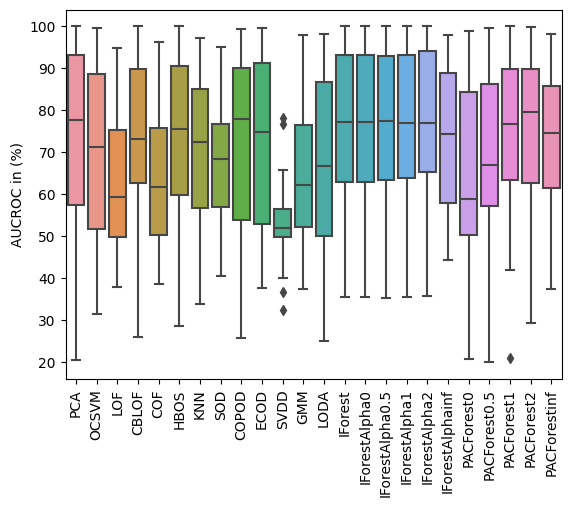

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.boxplot(data=merged)
plt.xticks(rotation=90)
ax.set(ylabel='AUCROC in (%)')
plt.show()

# AUCROC table with the best variants and SOTA algorithms using selected datasets

In [60]:
indeces_of_datasets_best_variants = ["annthyroid","cover","landsat","thyroid","Waveform","wine","WPBC"]

table_1 = df_AUCROC_sota_results.set_index("Datasets").loc[indeces_of_datasets_best_variants]

table_2 = df_AUCROC_If_variants.set_index("Datasets").loc[indeces_of_datasets_best_variants]

table_if_alpha = table_2[["IForestAlpha0","IForestAlpha0.5","IForestAlpha1","IForestAlpha2","IForestAlphainf"]]
best_if_alpha_algos = table_if_alpha.idxmax(axis=1).values

table_if_pac_alpha = table_2[["PACForest0","PACForest0.5","PACForest1","PACForest2","PACForestinf"]]
best_if_pac_algos = table_if_pac_alpha.idxmax(axis=1).values

if_pac_alpha_values = []
for i, c in enumerate(indeces_of_datasets_best_variants):
    if_pac_alpha_values.append(f"{np.round(table_if_pac_alpha.at[c,best_if_pac_algos[i]],2)} ({best_if_pac_algos[i]})")

if_alpha_values = []
for i, c in enumerate(indeces_of_datasets_best_variants):
    if_alpha_values.append(f"{np.round(table_if_alpha.at[c,best_if_alpha_algos[i]],2)} ({best_if_alpha_algos[i]})")

if_variants_best_algos = pd.DataFrame(data=np.vstack([if_alpha_values,if_pac_alpha_values]).T)
if_variants_best_algos.columns = ["if alpha variant", "PAC if variant"]
if_variants_best_algos["Datasets"] = indeces_of_datasets_best_variants
if_variants_best_algos = if_variants_best_algos.set_index("Datasets")

table_1["IForest"] = table_2["IForest"]
df_comp_sota_vs_if_variants = table_1.join(if_variants_best_algos)

# Summarized table

In [61]:
st = df_comp_sota_vs_if_variants.loc[:,  ~df_comp_sota_vs_if_variants.columns.isin(['if alpha variant','PAC if variant'])]

st = st.astype(float)
best_sota_algos_relevant_datasets = st.idxmax(axis=1).values
best_sota_algos_relevant_datasets

values = []
for i, c in enumerate(indeces_of_datasets_best_variants):
    values.append(f"{np.round(st.at[c,best_sota_algos_relevant_datasets[i]],2)} ({best_sota_algos_relevant_datasets[i]})")

final_st = pd.DataFrame(data=df_comp_sota_vs_if_variants[['if alpha variant','PAC if variant']].values, columns=['if alpha variant','PAC if variant'],index=st.index)
final_st["best SOTA algorithm"] = values

# ADBench IForest results vs our results

In [62]:
np.round((merged["IForest"].values - adbench_IForest_aucroc.loc[merged.index].astype(float).values.flatten()).mean() ,2)

0.06